In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from scheduler import schedule_agent, UserProfile, ScheduleState
import os
os.environ["LANGCHAIN_PROJECT"] = "agent_test"

INFO:qdrant_manager:loading embeddings
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda:0
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: Snowflake/snowflake-arctic-embed-l-v2.0
INFO:sentence_transformers.SentenceTransformer:1 prompts are loaded, with the keys: ['query']
INFO:qdrant_manager:loaded embeddings
INFO:qdrant_manager:initializing qdrant manager with host: localhost, port: 6333
INFO:scheduler:initializing schedule agent
INFO:scheduler:compiled workflow
INFO:scheduler:created schedule agent


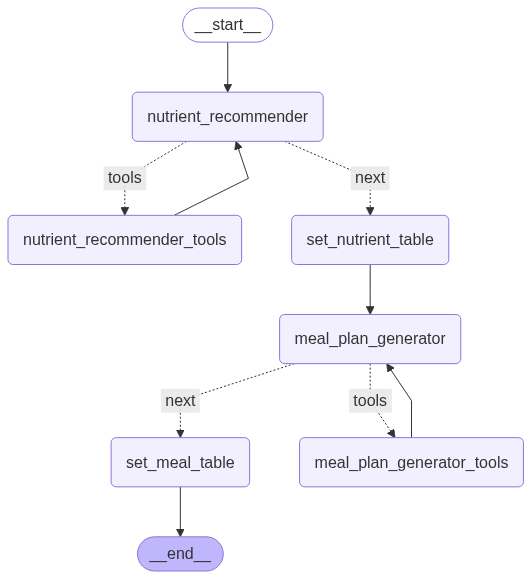

In [2]:
from IPython.display import Image, display
display(Image(schedule_agent.get_graph_image()))

In [2]:
user_profile = UserProfile(
        age=20,
        gender="남성",
        height=180,
        weight=70,
        diseases=["비만"],
        favorite_foods=["치킨"],
        disliked_foods=["빵"]
    )
schedule_state = ScheduleState(
    user_profile,
    recommender_messages=[],
    plan_messages=[],
    nutrient_table="",
    meal_table="",
    nutrient_binary_score="",
    plan_binary_score=""
)
print(schedule_state)

{'age': 20, 'gender': '남성', 'height': 180.0, 'weight': 70.0, 'diseases': ['비만'], 'favorite_foods': ['치킨'], 'disliked_foods': ['빵'], 'recommender_messages': [], 'plan_messages': [], 'nutrient_table': '', 'meal_table': '', 'nutrient_binary_score': '', 'plan_binary_score': ''}


In [3]:
result_logs = []

for event in schedule_agent.app.stream(
    input={"user_profile": user_profile, "keywords": "달달한"}, 
    config={"configurable": {"thread_id": "123"}}
):
    for value in event.values():
        print(value)
        result_logs.append(value)
        print("--------------------------------")

{'recommender_messages': [AIMessage(content='Okay, I will use the retriever tool to find the recommended daily intake for the given user profile, considering their age, gender, height, weight, and the presence of obesity. I will focus on retrieving information related to calorie, carbohydrate, sugar, protein, saturated fat, trans fat, cholesterol, and sodium intake for obese men in their 20s.', additional_kwargs={'function_call': {'name': 'retriever', 'arguments': '{"query": "20\\ub300 \\ub0a8\\uc131 \\ube44\\ub9cc \\ud658\\uc790 \\uc77c\\uc77c \\uad8c\\uc7a5 \\uc12d\\ucde8\\ub7c9 \\uc5f4\\ub7c9, \\ud0c4\\uc218\\ud654\\ubb3c, \\ub2f9\\ub958, \\ub2e8\\ubc31\\uc9c8, \\ud3ec\\ud654\\uc9c0\\ubc29, \\ud2b8\\ub79c\\uc2a4\\uc9c0\\ubc29, \\ucf5c\\ub808\\uc2a4\\ud14c\\ub864, \\ub098\\ud2b8\\ub968"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--f441a84b-1052-4363-8262

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

In [6]:
for log in result_logs:
    if "nutrient_table" in log.keys():
        print_result(log)
        break

nutrient_table: {
  energy_kcal: 2500.0
  protein_g: 125.0
  fat_g: 69.44
  carbohydrate_g: 343.75
  sugars_g: 62.5
  sodium_mg: 2000.0
  cholesterol_mg: 300.0
  saturated_fat_g: 19.44
  trans_fat_g: 0.0
}


In [7]:
print(result_logs[-2]["plan_messages"][-1].content)

```json
[
    {
        "day": "2024-07-01",
        "meals": [
            {
                "time_slot": "08:00",
                "food_list": [
                    "오트밀",
                    "바나나",
                    "아몬드"
                ]
            },
            {
                "time_slot": "13:00",
                "food_list": [
                    "현미밥",
                    "닭가슴살",
                    "김치"
                ]
            },
            {
                "time_slot": "19:00",
                "food_list": [
                    "두부",
                    "고구마",
                    "김치"
                ]
            }
        ],
        "nutrients": {
            "energy_kcal": 772.0,
            "protein_g": 41.91,
            "fat_g": 50.06,
            "carbohydrate_g": 169.39,
            "sugars_g": 64.13,
            "sodium_mg": 505.0,
            "cholesterol_mg": 19.43,
            "saturated_fat_g": 6.46,
            "trans_fat_g": 0.2
        }
    },


In [5]:
def print_result(result_a: dict, depth: int = 0):
    for k, v in result_a.items():
        print("  " * depth + k, end=": ")
        if isinstance(v, list):
            print("[")
            for i in v:
                if isinstance(i, dict):
                    print("  " * (depth+1) + "{")
                    print_result(i, depth + 2)
                    print("  " * (depth+1) + "}")
                else:
                    print("  " * (depth+1) + str(i))
            print("  " * depth + "]")
        elif isinstance(v, dict):
            print("{")
            print_result(v, depth + 1)
            print("  " * depth + "}")
        else:
            print(str(v))

print_result(result_logs[-1], depth=1)

  meal_table: {
    days: [
      {
        day: 2024-07-01
        meals: [
          {
            time_slot: 08:00:00
            food_list: [
              오트밀
              바나나
              아몬드
            ]
          }
          {
            time_slot: 13:00:00
            food_list: [
              현미밥
              닭가슴살
              김치
            ]
          }
          {
            time_slot: 19:00:00
            food_list: [
              두부
              고구마
              김치
            ]
          }
        ]
        nutrients: {
          energy_kcal: 772.0
          protein_g: 41.91
          fat_g: 50.06
          carbohydrate_g: 169.39
          sugars_g: 64.13
          sodium_mg: 505.0
          cholesterol_mg: 19.43
          saturated_fat_g: 6.46
          trans_fat_g: 0.2
        }
      }
      {
        day: 2024-07-02
        meals: [
          {
            time_slot: 08:00:00
            food_list: [
              오트밀
              사과
              아몬드
  

In [13]:
import json
from tools import WeeklyMealPlan, Meal, DailyPlan

In [15]:
result_dict = json.loads(value["plan_messages"][-1].content.replace("```json\n", "").replace("```", ""))
result_dict

{'meal_plan': {'days': [{'day': '2024-07-01',
    'meals': [{'time_slot': '08:00', 'food_list': ['오트밀', '바나나']},
     {'time_slot': '13:00', 'food_list': ['닭가슴살 샐러드', '현미밥']},
     {'time_slot': '19:00', 'food_list': ['두부조림', '삶은 달걀 2개', '현미밥']}]},
   {'day': '2024-07-02',
    'meals': [{'time_slot': '08:00', 'food_list': ['사과', '그릭요거트']},
     {'time_slot': '13:00', 'food_list': ['닭볶음탕', '현미밥']},
     {'time_slot': '19:00', 'food_list': ['고구마', '닭가슴살 샐러드']}]},
   {'day': '2024-07-03',
    'meals': [{'time_slot': '08:00', 'food_list': ['시리얼', '우유']},
     {'time_slot': '13:00', 'food_list': ['김치찌개', '현미밥']},
     {'time_slot': '19:00', 'food_list': ['두부조림', '삶은 달걀 2개', '현미밥']}]},
   {'day': '2024-07-04',
    'meals': [{'time_slot': '08:00', 'food_list': ['바나나', '견과류']},
     {'time_slot': '13:00', 'food_list': ['닭가슴살 샐러드', '현미밥']},
     {'time_slot': '19:00', 'food_list': ['스테이크 도시락']}]},
   {'day': '2024-07-05',
    'meals': [{'time_slot': '08:00', 'food_list': ['오트밀', '우유']},
     {'

In [19]:
for day in result_dict["meal_plan"]["days"]:
    for meal in day["meals"]:
        print(meal["time_slot"])
        for food in meal["food_list"]:
            print(food)
        print()

08:00
오트밀
바나나

13:00
닭가슴살 샐러드
현미밥

19:00
두부조림
삶은 달걀 2개
현미밥

08:00
사과
그릭요거트

13:00
닭볶음탕
현미밥

19:00
고구마
닭가슴살 샐러드

08:00
시리얼
우유

13:00
김치찌개
현미밥

19:00
두부조림
삶은 달걀 2개
현미밥

08:00
바나나
견과류

13:00
닭가슴살 샐러드
현미밥

19:00
스테이크 도시락

08:00
오트밀
우유

13:00
잡채
현미밥

19:00
두부조림
삶은 달걀 2개
현미밥

08:00
사과
그릭요거트

13:00
닭볶음탕
현미밥

19:00
고구마
닭가슴살 샐러드

08:00
시리얼
우유

13:00
김치찌개
현미밥

19:00
탕수육
현미밥



In [4]:
from qdrant_manager import qdrant_manager

In [7]:
query = "20세 남성, 비만 환자의 일일 권장 영양소 섭취량"

In [ ]:
qdrant_manager.get_documents("20세 남성, 비만 환자의 일일 권장 영양소 섭취량", collection_name=qdrant_manager.collection_names.food_docs_collection)

In [ ]:
docs_retriever = qdrant_manager.get_retriever(qdrant_manager.collection_names.food_docs_collection)

In [ ]:
docs_retriever.invoke(query)

In [9]:
from tools import retriever_tool

In [ ]:
retriever_tool.invoke(query)

In [1]:
from tools import generate_weekly_meal_plan
from langchain_google_genai import ChatGoogleGenerativeAI

In [2]:
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0.0)
llm_tool = llm.bind_tools([generate_weekly_meal_plan])

In [7]:
result = llm_tool.invoke("적당히 랜덤한 meal_plan을 생성해서 generate_weekly_meal_plan 라는 툴을 사용해줘")

In [9]:

result.__dict__

{'content': '',
 'additional_kwargs': {'function_call': {'name': 'generate_weekly_meal_plan',
   'arguments': '{"meal_plan": {"days": [{"day": "2024-07-01", "meals": [{"time_slot": "08:00", "food_list": ["apple", "banana"]}, {"time_slot": "12:00", "food_list": ["sandwich", "salad"]}, {"time_slot": "18:00", "food_list": ["steak", "potatoes"]}]}, {"day": "2024-07-02", "meals": [{"time_slot": "08:00", "food_list": ["cereal", "milk"]}, {"time_slot": "12:00", "food_list": ["soup", "bread"]}, {"time_slot": "18:00", "food_list": ["chicken", "rice"]}]}, {"day": "2024-07-03", "meals": [{"time_slot": "08:00", "food_list": ["toast", "eggs"]}, {"time_slot": "12:00", "food_list": ["pasta", "sauce"]}, {"time_slot": "18:00", "food_list": ["fish", "vegetables"]}]}, {"day": "2024-07-04", "meals": [{"time_slot": "08:00", "food_list": ["yogurt", "granola"]}, {"time_slot": "12:00", "food_list": ["pizza"]}, {"time_slot": "18:00", "food_list": ["burgers", "fries"]}]}, {"day": "2024-07-05", "meals": [{"time_

In [12]:
result.tool_calls[0]

{'name': 'generate_weekly_meal_plan',
 'args': {'meal_plan': {'days': [{'day': '2024-07-01',
     'meals': [{'time_slot': '08:00', 'food_list': ['apple', 'banana']},
      {'time_slot': '12:00', 'food_list': ['sandwich', 'salad']},
      {'time_slot': '18:00', 'food_list': ['steak', 'potatoes']}]},
    {'day': '2024-07-02',
     'meals': [{'time_slot': '08:00', 'food_list': ['cereal', 'milk']},
      {'time_slot': '12:00', 'food_list': ['soup', 'bread']},
      {'time_slot': '18:00', 'food_list': ['chicken', 'rice']}]},
    {'day': '2024-07-03',
     'meals': [{'time_slot': '08:00', 'food_list': ['toast', 'eggs']},
      {'time_slot': '12:00', 'food_list': ['pasta', 'sauce']},
      {'time_slot': '18:00', 'food_list': ['fish', 'vegetables']}]},
    {'day': '2024-07-04',
     'meals': [{'time_slot': '08:00', 'food_list': ['yogurt', 'granola']},
      {'time_slot': '12:00', 'food_list': ['pizza']},
      {'time_slot': '18:00', 'food_list': ['burgers', 'fries']}]},
    {'day': '2024-07-05

In [ ]:
```json
[
    {
        "day": "2024-07-01",
        "meals": [
            {
                "time_slot": "08:00",
                "food_list": [
                    {
                        "food_name": "현미밥",
                        "nutrients": {
                            "energy_kcal": 118.0,
                            "protein_g": 2.2,
                            "fat_g": 0.36,
                            "carbohydrate_g": 25.4,
                            "sugars_g": 0.17,
                            "sodium_mg": 1.0,
                            "cholesterol_mg": 0.0,
                            "saturated_fat_g": 0.1,
                            "trans_fat_g": 0.0
                        }
                    },
                    {
                        "food_name": "두부",
                        "nutrients": {
                            "energy_kcal": 85.0,
                            "protein_g": 8.5,
                            "fat_g": 4.6,
                            "carbohydrate_g": 2.6,
                            "sugars_g": 0.5,
                            "sodium_mg": 12.0,
                            "cholesterol_mg": 0.0,
                            "saturated_fat_g": 1.3,
                            "trans_fat_g": 0.0
                        }
                    },
                    {
                        "food_name": "김치찌개",
                        "nutrients": {
                            "energy_kcal": 52.0,
                            "protein_g": 2.22,
                            "fat_g": 0.69,
                            "carbohydrate_g": 9.19,
                            "sugars_g": 6.07,
                            "sodium_mg": 1247.0,
                            "cholesterol_mg": 0.0,
                            "saturated_fat_g": 0.14,
                            "trans_fat_g": 0.0
                        }
                    }
                ]
            },
            {
                "time_slot": "13:00",
                "food_list": [
                    {
                        "food_name": "닭목살 구이",
                        "nutrients": {
                            "energy_kcal": 210.0,
                            "protein_g": 15.33,
                            "fat_g": 15.06,
                            "carbohydrate_g": 3.18,
                            "sugars_g": 0.85,
                            "sodium_mg": 326.0,
                            "cholesterol_mg": 78.17,
                            "saturated_fat_g": 4.09,
                            "trans_fat_g": 0.04
                        }
                    },
                    {
                        "food_name": "샐러드_샐러드",
                        "nutrients": {
                            "energy_kcal": 15.0,
                            "protein_g": 1.0,
                            "fat_g": 0.0,
                            "carbohydrate_g": 0.0,
                            "sugars_g": 0.0,
                            "sodium_mg": 12.0,
                            "cholesterol_mg": 0.0,
                            "saturated_fat_g": 0.0,
                            "trans_fat_g": 0.0
                        }
                    },
                    {
                        "food_name": "고구마",
                        "nutrients": {
                            "energy_kcal": 143.0,
                            "protein_g": 1.16,
                            "fat_g": 0.35,
                            "carbohydrate_g": 33.73,
                            "sugars_g": 11.01,
                            "sodium_mg": 6.0,
                            "cholesterol_mg": 0.0,
                            "saturated_fat_g": 0.03,
                            "trans_fat_g": 0.0
                        }
                    }
                ]
            },
            {
                "time_slot": "19:00",
                "food_list": [
                    {
                        "food_name": "생선구이",
                        "nutrients": {
                            "energy_kcal": 36.0,
                            "protein_g": 7.53,
                            "fat_g": 0.39,
                            "carbohydrate_g": 0.09,
                            "sugars_g": 0.0,
                            "sodium_mg": 116.0,
                            "cholesterol_mg": 25.0,
                            "saturated_fat_g": 0.0,
                            "trans_fat_g": 0.0
                        }
                    },
                    {
                        "food_name": "잡곡밥",
                        "nutrients": {
                            "energy_kcal": 146.0,
                            "protein_g": 5.3,
                            "fat_g": 0.87,
                            "carbohydrate_g": 29.33,
                            "sugars_g": 0.32,
                            "sodium_mg": 3.0,
                            "cholesterol_mg": 0.0,
                            "saturated_fat_g": 0.22,
                            "trans_fat_g": 0.0
                        }
                    },
                    {
                        "food_name": "된장찌개",
                        "nutrients": {
                            "energy_kcal": 21.0,
                            "protein_g": 1.2,
                            "fat_g": 0.24,
                            "carbohydrate_g": 3.6,
                            "sugars_g": 1.2,
                            "sodium_mg": 322.0,
                            "cholesterol_mg": 0.4,
                            "saturated_fat_g": 0.0,
                            "trans_fat_g": 0.0
                        }
                    }
                ]
            }
        ]
    },
    {
        "day": "2024-07-02",
        "meals": [
            {
                "time_slot": "08:00",
                "food_list": [
                    {
                        "food_name": "오렌지",
                        "nutrients": {
                            "energy_kcal": 23.0,
                            "protein_g": 0.0,
                            "fat_g": 0.0,
                            "carbohydrate_g": 5.71,
                            "sugars_g": 5.71,
                            "sodium_mg": 14.0,
                            "cholesterol_mg": 0.0,
                            "saturated_fat_g": 0.0,
                            "trans_fat_g": 0.0
                        }
                    },
                    {
                        "food_name": "견과류 연근조림",
                        "nutrients": {
                            "energy_kcal": 60.0,
                            "protein_g": 2.0,
                            "fat_g": 2.5,
                            "carbohydrate_g": 7.0,
                            "sugars_g": 2.0,
                            "sodium_mg": 65.0,
                            "cholesterol_mg": 0.0,
                            "saturated_fat_g": 0.0,
                            "trans_fat_g": 0.0
                        }
                    },
                    {
                        "food_name": "요거트",
                        "nutrients": {
                            "energy_kcal": 138.0,
                            "protein_g": 2.4,
                            "fat_g": 3.1,
                            "carbohydrate_g": 25.2,
                            "sugars_g": 25.0,
                            "sodium_mg": 88.0,
                            "cholesterol_mg": 18.9,
                            "saturated_fat_g": 1.6,
                            "trans_fat_g": 0.0
                        }
                    }
                ]
            },
            {
                "time_slot": "13:00",
                "food_list": [
                    {
                        "food_name": "닭목살 구이",
                        "nutrients": {
                            "energy_kcal": 210.0,
                            "protein_g": 15.33,
                            "fat_g": 15.06,
                            "carbohydrate_g": 3.18,
                            "sugars_g": 0.85,
                            "sodium_mg": 326.0,
                            "cholesterol_mg": 78.17,
                            "saturated_fat_g": 4.09,
                            "trans_fat_g": 0.04
                        }
                    },
                    {
                        "food_name": "샐러드_샐러드",
                        "nutrients": {
                            "energy_kcal": 15.0,
                            "protein_g": 1.0,
                            "fat_g": 0.0,
                            "carbohydrate_g": 0.0,
                            "sugars_g": 0.0,
                            "sodium_mg": 12.0,
                            "cholesterol_mg": 0.0,
                            "saturated_fat_g": 0.0,
                            "trans_fat_g": 0.0
                        }
                    },
                    {
                        "food_name": "고구마",
                        "nutrients": {
                            "energy_kcal": 143.0,
                            "protein_g": 1.16,
                            "fat_g": 0.35,
                            "carbohydrate_g": 33.73,
                            "sugars_g": 11.01,
                            "sodium_mg": 6.0,
                            "cholesterol_mg": 0.0,
                            "saturated_fat_g": 0.03,
                            "trans_fat_g": 0.0
                        }
                    }
                ]
            },
            {
                "time_slot": "19:00",
                "food_list": [
                    {
                        "food_name": "생선구이",
                        "nutrients": {
                            "energy_kcal": 36.0,
                            "protein_g": 7.53,
                            "fat_g": 0.39,
                            "carbohydrate_g": 0.09,
                            "sugars_g": 0.0,
                            "sodium_mg": 116.0,
                            "cholesterol_mg": 25.0,
                            "saturated_fat_g": 0.0,
                            "trans_fat_g": 0.0
                        }
                    },
                    {
                        "food_name": "잡곡밥",
                        "nutrients": {
                            "energy_kcal": 146.0,
                            "protein_g": 5.3,
                            "fat_g": 0.87,
                            "carbohydrate_g": 29.33,
                            "sugars_g": 0.32,
                            "sodium_mg": 3.0,
                            "cholesterol_mg": 0.0,
                            "saturated_fat_g": 0.22,
                            "trans_fat_g": 0.0
                        }
                    },
                    {
                        "food_name": "된장찌개",
                        "nutrients": {
                            "energy_kcal": 21.0,
                            "protein_g": 1.2,
                            "fat_g": 0.24,
                            "carbohydrate_g": 3.6,
                            "sugars_g": 1.2,
                            "sodium_mg": 322.0,
                            "cholesterol_mg": 0.4,
                            "saturated_fat_g": 0.0,
                            "trans_fat_g": 0.0
                        }
                    }
                ]
            }
        ]
    },
    {
        "day": "2024-07-03",
        "meals": [
            {
                "time_slot": "08:00",
                "food_list": [
                    {
                        "food_name": "오렌지",
                        "nutrients": {
                            "energy_kcal": 23.0,
                            "protein_g": 0.0,
                            "fat_g": 0.0,
                            "carbohydrate_g": 5.71,
                            "sugars_g": 5.71,
                            "sodium_mg": 14.0,
                            "cholesterol_mg": 0.0,
                            "saturated_fat_g": 0.0,
                            "trans_fat_g": 0.0
                        }
                    },
                    {
                        "food_name": "견과류 연근조림",
                        "nutrients": {
                            "energy_kcal": 60.0,
                            "protein_g": 2.0,
                            "fat_g": 2.5,
                            "carbohydrate_g": 7.0,
                            "sugars_g": 2.0,
                            "sodium_mg": 65.0,
                            "cholesterol_mg": 0.0,
                            "saturated_fat_g": 0.0,
                            "trans_fat_g": 0.0
                        }
                    },
                    {
                        "food_name": "요거트",
                        "nutrients": {
                            "energy_kcal": 138.0,
                            "protein_g": 2.4,
                            "fat_g": 3.1,
                            "carbohydrate_g": 25.2,
                            "sugars_g": 25.0,
                            "sodium_mg": 88.0,
                            "cholesterol_mg": 18.9,
                            "saturated_fat_g": 1.6,
                            "trans_fat_g": 0.0
                        }
                    }
                ]
            },
            {
                "time_slot": "13:00",
                "food_list": [
                    {
                        "food_name": "닭목살 구이",
                        "nutrients": {
                            "energy_kcal": 210.0,
                            "protein_g": 15.33,
                            "fat_g": 15.06,
                            "carbohydrate_g": 3.18,
                            "sugars_g": 0.85,
                            "sodium_mg": 326.0,
                            "cholesterol_mg": 78.17,
                            "saturated_fat_g": 4.09,
                            "trans_fat_g": 0.04
                        }
                    },
                    {
                        "food_name": "샐러드_샐러드",
                        "nutrients": {
                            "energy_kcal": 15.0,
                            "protein_g": 1.0,
                            "fat_g": 0.0,
                            "carbohydrate_g": 0.0,
                            "sugars_g": 0.0,
                            "sodium_mg": 12.0,
                            "cholesterol_mg": 0.0,
                            "saturated_fat_g": 0.0,
                            "trans_fat_g": 0.0
                        }
                    },
                    {
                        "food_name": "고구마",
                        "nutrients": {
                            "energy_kcal": 143.0,
                            "protein_g": 1.16,
                            "fat_g": 0.35,
                            "carbohydrate_g": 33.73,
                            "sugars_g": 11.01,
                            "sodium_mg": 6.0,
                            "cholesterol_mg": 0.0,
                            "saturated_fat_g": 0.03,
                            "trans_fat_g": 0.0
                        }
                    }
                ]
            },
            {
                "time_slot": "19:00",
                "food_list": [
                    {
                        "food_name": "생선구이",
                        "nutrients": {
                            "energy_kcal": 36.0,
                            "protein_g": 7.53,
                            "fat_g": 0.39,
                            "carbohydrate_g": 0.09,
                            "sugars_g": 0.0,
                            "sodium_mg": 116.0,
                            "cholesterol_mg": 25.0,
                            "saturated_fat_g": 0.0,
                            "trans_fat_g": 0.0
                        }
                    },
                    {
                        "food_name": "잡곡밥",
                        "nutrients": {
                            "energy_kcal": 146.0,
                            "protein_g": 5.3,
                            "fat_g": 0.87,
                            "carbohydrate_g": 29.33,
                            "sugars_g": 0.32,
                            "sodium_mg": 3.0,
                            "cholesterol_mg": 0.0,
                            "saturated_fat_g": 0.22,
                            "trans_fat_g": 0.0
                        }
                    },
                    {
                        "food_name": "된장찌개",
                        "nutrients": {
                            "energy_kcal": 21.0,
                            "protein_g": 1.2,
                            "fat_g": 0.24,
                            "carbohydrate_g": 3.6,
                            "sugars_g": 1.2,
                            "sodium_mg": 322.0,
                            "cholesterol_mg": 0.4,
                            "saturated_fat_g": 0.0,
                            "trans_fat_g": 0.0
                        }
                    }
                ]
            }
        ]
    },
    {
        "day": "2024-07-04",
        "meals": [
            {
                "time_slot": "08:00",
                "food_list": [
                    {
                        "food_name": "오렌지",
                        "nutrients": {
                            "energy_kcal": 23.0,
                            "protein_g": 0.0,
                            "fat_g": 0.0,
                            "carbohydrate_g": 5.71,
                            "sugars_g": 5.71,
                            "sodium_mg": 14.0,
                            "cholesterol_mg": 0.0,
                            "saturated_fat_g": 0.0,
                            "trans_fat_g": 0.0
                        }
                    },
                    {
                        "food_name": "견과류 연근조림",
                        "nutrients": {
                            "energy_kcal": 60.0,
                            "protein_g": 2.0,
                            "fat_g": 2.5,
                            "carbohydrate_g": 7.0,
                            "sugars_g": 2.0,
                            "sodium_mg": 65.0,
                            "cholesterol_mg": 0.0,
                            "saturated_fat_g": 0.0,
                            "trans_fat_g": 0.0
                        }
                    },
                    {
                        "food_name": "요거트",
                        "nutrients": {
                            "energy_kcal": 138.0,
                            "protein_g": 2.4,
                            "fat_g": 3.1,
                            "carbohydrate_g": 25.2,
                            "sugars_g": 25.0,
                            "sodium_mg": 88.0,
                            "cholesterol_mg": 18.9,
                            "saturated_fat_g": 1.6,
                            "trans_fat_g": 0.0
                        }
                    }
                ]
            },
            {
                "time_slot": "13:00",
                "food_list": [
                    {
                        "food_name": "닭목살 구이",
                        "nutrients": {
                            "energy_kcal": 210.0,
                            "protein_g": 15.33,
                            "fat_g": 15.06,
                            "carbohydrate_g": 3.18,
                            "sugars_g": 0.85,
                            "sodium_mg": 326.0,
                            "cholesterol_mg": 78.17,
                            "saturated_fat_g": 4.09,
                            "trans_fat_g": 0.04
                        }
                    },
                    {
                        "food_name": "샐러드_샐러드",
                        "nutrients": {
                            "energy_kcal": 15.0,
                            "protein_g": 1.0,
                            "fat_g": 0.0,
                            "carbohydrate_g": 0.0,
                            "sugars_g": 0.0,
                            "sodium_mg": 12.0,
                            "cholesterol_mg": 0.0,
                            "saturated_fat_g": 0.0,
                            "trans_fat_g": 0.0
                        }
                    },
                    {
                        "food_name": "고구마",
                        "nutrients": {
                            "energy_kcal": 143.0,
                            "protein_g": 1.16,
                            "fat_g": 0.35,
                            "carbohydrate_g": 33.73,
                            "sugars_g": 11.01,
                            "sodium_mg": 6.0,
                            "cholesterol_mg": 0.0,
                            "saturated_fat_g": 0.03,
                            "trans_fat_g": 0.0
                        }
                    }
                ]
            },
            {
                "time_slot": "19:00",
                "food_list": [
                    {
                        "food_name": "생선구이",
                        "nutrients": {
                            "energy_kcal": 36.0,
                            "protein_g": 7.53,
                            "fat_g": 0.39,
                            "carbohydrate_g": 0.09,
                            "sugars_g": 0.0,
                            "sodium_mg": 116.0,
                            "cholesterol_mg": 25.0,
                            "saturated_fat_g": 0.0,
                            "trans_fat_g": 0.0
                        }
                    },
                    {
                        "food_name": "잡곡밥",
                        "nutrients": {
                            "energy_kcal": 146.0,
                            "protein_g": 5.3,
                            "fat_g": 0.87,
                            "carbohydrate_g": 29.33,
                            "sugars_g": 0.32,
                            "sodium_mg": 3.0,
                            "cholesterol_mg": 0.0,
                            "saturated_fat_g": 0.22,
                            "trans_fat_g": 0.0
                        }
                    },
                    {
                        "food_name": "된장찌개",
                        "nutrients": {
                            "energy_kcal": 21.0,
                            "protein_g": 1.2,
                            "fat_g": 0.24,
                            "carbohydrate_g": 3.6,
                            "sugars_g": 1.2,
                            "sodium_mg": 322.0,
                            "cholesterol_mg": 0.4,
                            "saturated_fat_g": 0.0,
                            "trans_fat_g": 0.0
                        }
                    }
                ]
            }
        ]
    },
    {
        "day": "2024-07-05",
        "meals": [
            {
                "time_slot": "08:00",
                "food_list": [
                    {
                        "food_name": "오렌지",
                        "nutrients": {
                            "energy_kcal": 23.0,
                            "protein_g": 0.0,
                            "fat_g": 0.0,
                            "carbohydrate_g": 5.71,
                            "sugars_g": 5.71,
                            "sodium_mg": 14.0,
                            "cholesterol_mg": 0.0,
                            "saturated_fat_g": 0.0,
                            "trans_fat_g": 0.0
                        }
                    },
                    {
                        "food_name": "견과류 연근조림",
                        "nutrients": {
                            "energy_kcal": 60.0,
                            "protein_g": 2.0,
                            "fat_g": 2.5,
                            "carbohydrate_g": 7.0,
                            "sugars_g": 2.0,
                            "sodium_mg": 65.0,
                            "cholesterol_mg": 0.0,
                            "saturated_fat_g": 0.0,
                            "trans_fat_g": 0.0
                        }
                    },
                    {
                        "food_name": "요거트",
                        "nutrients": {
                            "energy_kcal": 138.0,
                            "protein_g": 2.4,
                            "fat_g": 3.1,
                            "carbohydrate_g": 25.2,
                            "sugars_g": 25.0,
                            "sodium_mg": 88.0,
                            "cholesterol_mg": 18.9,
                            "saturated_fat_g": 1.6,
                            "trans_fat_g": 0.0
                        }
                    }
                ]
            },
            {
                "time_slot": "13:00",
                "food_list": [
                    {
                        "food_name": "닭목살 구이",
                        "nutrients": {
                            "energy_kcal": 210.0,
                            "protein_g": 15.33,
                            "fat_g": 15.06,
                            "carbohydrate_g": 3.18,
                            "sugars_g": 0.85,
                            "sodium_mg": 326.0,
                            "cholesterol_mg": 78.17,
                            "saturated_fat_g": 4.09,
                            "trans_fat_g": 0.04
                        }
                    },
                    {
                        "food_name": "샐러드_샐러드",
                        "nutrients": {
                            "energy_kcal": 15.0,
                            "protein_g": 1.0,
                            "fat_g": 0.0,
                            "carbohydrate_g": 0.0,
                            "sugars_g": 0.0,
                            "sodium_mg": 12.0,
                            "cholesterol_mg": 0.0,
                            "saturated_fat_g": 0.0,
                            "trans_fat_g": 0.0
                        }
                    },
                    {
                        "food_name": "고구마",
                        "nutrients": {
                            "energy_kcal": 143.0,
                            "protein_g": 1.16,
                            "fat_g": 0.35,
                            "carbohydrate_g": 33.73,
                            "sugars_g": 11.01,
                            "sodium_mg": 6.0,
                            "cholesterol_mg": 0.0,
                            "saturated_fat_g": 0.03,
                            "trans_fat_g": 0.0
                        }
                    }
                ]
            },
            {
                "time_slot": "19:00",
                "food_list": [
                    {
                        "food_name": "생선구이",
                        "nutrients": {
                            "energy_kcal": 36.0,
                            "protein_g": 7.53,
                            "fat_g": 0.39,
                            "carbohydrate_g": 0.09,
                            "sugars_g": 0.0,
                            "sodium_mg": 116.0,
                            "cholesterol_mg": 25.0,
                            "saturated_fat_g": 0.0,
                            "trans_fat_g": 0.0
                        }
                    },
                    {
                        "food_name": "잡곡밥",
                        "nutrients": {
                            "energy_kcal": 146.0,
                            "protein_g": 5.3,
                            "fat_g": 0.87,
                            "carbohydrate_g": 29.33,
                            "sugars_g": 0.32,
                            "sodium_mg": 3.0,
                            "cholesterol_mg": 0.0,
                            "saturated_fat_g": 0.22,
                            "trans_fat_g": 0.0
                        }
                    },
                    {
                        "food_name": "된장찌개",
                        "nutrients": {
                            "energy_kcal": 21.0,
                            "protein_g": 1.2,
                            "fat_g": 0.24,
                            "carbohydrate_g": 3.6,
                            "sugars_g": 1.2,
                            "sodium_mg": 322.0,
                            "cholesterol_mg": 0.4,
                            "saturated_fat_g": 0.0,
                            "trans_fat_g": 0.0
                        }
                    }
                ]
            }
        ]
    },
    {
        "day": "2024-07-06",
        "meals": [
            {
                "time_slot": "08:00",
                "food_list": [
                    {
                        "food_name": "오렌지",
                        "nutrients": {
                            "energy_kcal": 23.0,
                            "protein_g": 0.0,
                            "fat_g": 0.0,
                            "carbohydrate_g": 5.71,
                            "sugars_g": 5.71,
                            "sodium_mg": 14.0,
                            "cholesterol_mg": 0.0,
                            "saturated_fat_g": 0.0,
                            "trans_fat_g": 0.0
                        }
                    },
                    {
                        "food_name": "견과류 연근조림",
                        "nutrients": {
                            "energy_kcal": 60.0,
                            "protein_g": 2.0,
                            "fat_g": 2.5,
                            "carbohydrate_g": 7.0,
                            "sugars_g": 2.0,
                            "sodium_mg": 65.0,
                            "cholesterol_mg": 0.0,
                            "saturated_fat_g": 0.0,
                            "trans_fat_g": 0.0
                        }
                    },
                    {
                        "food_name": "요거트",
                        "nutrients": {
                            "energy_kcal": 138.0,
                            "protein_g": 2.4,
                            "fat_g": 3.1,
                            "carbohydrate_g": 25.2,
                            "sugars_g": 25.0,
                            "sodium_mg": 88.0,
                            "cholesterol_mg": 18.9,
                            "saturated_fat_g": 1.6,
                            "trans_fat_g": 0.0
                        }
                    }
                ]
            },
            {
                "time_slot": "13:00",
                "food_list": [
                    {
                        "food_name": "닭목살 구이",
                        "nutrients": {
                            "energy_kcal": 210.0,
                            "protein_g": 15.33,
                            "fat_g": 15.06,
                            "carbohydrate_g": 3.18,
                            "sugars_g": 0.85,
                            "sodium_mg": 326.0,
                            "cholesterol_mg": 78.17,
                            "saturated_fat_g": 4.09,
                            "trans_fat_g": 0.04
                        }
                    },
                    {
                        "food_name": "샐러드_샐러드",
                        "nutrients": {
                            "energy_kcal": 15.0,
                            "protein_g": 1.0,
                            "fat_g":